# Overview
This jupyter notebook covers the following contents:
1. How to access dataset in LIBERO
2. How to place down multiple cameras in a scene to capture the scene.

In [1]:
from libero.libero import benchmark, get_libero_path
import matplotlib.pyplot as plt
import open3d as o3d
import numpy as np
import imageio
import os
from IPython.display import HTML

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def cammat2o3d(cam_mat, width, height):
    cx = cam_mat[0,2]
    fx = cam_mat[0,0]
    cy = cam_mat[1,2]
    fy = cam_mat[1,1]

    return o3d.camera.PinholeCameraIntrinsic(width, height, fx, fy, cx, cy)

def verticalFlip(img):
    return np.flip(img, axis=0)

def get_camera_position(sim, camera_name):
    camera_id = sim.model.camera_name2id(camera_name)
    camera_pos = sim.model.body_pos[camera_id]
    return camera_pos

def visualize_rgb_depth(rgb_img, depth_img):
    fig, ax = plt.subplots(1, 2, figsize=(15, 10))
    ax[0].imshow(verticalFlip(rgb_img))
    ax[0].set_title("RGB Image")
    ax[0].axis('off')  # Hide the axis
    cax = ax[1].imshow(verticalFlip(depth_img), cmap='tab20b')
    ax[1].set_title("Depth Image")
    ax[1].axis('off')  # Hide the axis
    fig.colorbar(cax, ax=ax[1])
    plt.show()

def create_video(images: list, name: str = "output", show: bool = False):
    video_writer = imageio.get_writer(f"{name}.mp4", fps=60)
    for image in images:
        video_writer.append_data(image[::-1])
    video_writer.close()

    if show:
        HTML("""
            <video width="640" height="480" controls>
                <source src="output.mp4" type="video/mp4">
            </video>
            <script>
                var video = document.getElementsByTagName('video')[0];
                video.playbackRate = 2.0; // Increase the playback speed to 2x
                </script>    
        """)

In [3]:

bddl_files_default_path = get_libero_path("bddl_files")

datasets = "libero_object" # "all", "libero_goal", "libero_spatial", "libero_object", "libero_100"
benchmark_dict = benchmark.get_benchmark_dict()
benchmark_instance = benchmark_dict[datasets]()
num_tasks = benchmark_instance.get_num_tasks()
demo_files = [os.path.join('/home/andang/neurips_2025/LIBERO/libero/datasets', benchmark_instance.get_task_demonstration(i)) for i in range(num_tasks)]

print(demo_files)

[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
['/home/andang/neurips_2025/LIBERO/libero/datasets/libero_object/pick_up_the_alphabet_soup_and_place_it_in_the_basket_demo.hdf5', '/home/andang/neurips_2025/LIBERO/libero/datasets/libero_object/pick_up_the_cream_cheese_and_place_it_in_the_basket_demo.hdf5', '/home/andang/neurips_2025/LIBERO/libero/datasets/libero_object/pick_up_the_salad_dressing_and_place_it_in_the_basket_demo.hdf5', '/home/andang/neurips_2025/LIBERO/libero/datasets/libero_object/pick_up_the_bbq_sauce_and_place_it_in_the_basket_demo.hdf5', '/home/andang/neurips_2025/LIBERO/libero/datasets/libero_object/pick_up_the_ketchup_and_place_it_in_the_basket_demo.hdf5', '/home/andang/neurips_2025/LIBERO/libero/datasets/libero_object/pick_up_the_tomato_sauce_and_place_it_in_the_basket_demo.hdf5', '/home/andang/neurips_2025/LIBERO/libero/datasets/libero_object/pick_up_the_butter_and_place_it_in_the_basket_demo.hdf5', '/home/andang/neurips_2025/LIBERO/libero/datasets/libero_o

['robot0_eye_in_hand', 'agentview']
['robot0_eye_in_hand_image', 'agentview_image', 'agentview1_image', 'agentview2_image', 'agentview3_image']


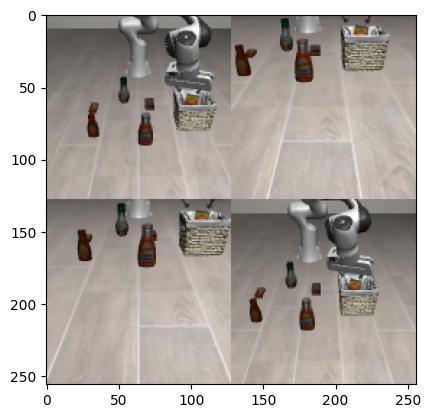

In [7]:

import h5py
from pathlib import Path
import json
from libero.libero.envs import OffScreenRenderEnv
from robosuite.utils.camera_utils import get_real_depth_map

demo_file = Path(demo_files[9])
bddl_path = str(Path(bddl_files_default_path) / demo_file.parent.stem / (demo_file.stem[:-5] + '.bddl'))

with h5py.File(demo_file, "r") as f:
    env_metadata = json.loads(f["data"].attrs["env_args"])
    data = f['data']
    demo = data['demo_0']
    states = demo['states'][()]

env_kwargs = env_metadata['env_kwargs']

env_kwargs['controller'] = env_kwargs.pop('controller_configs')['type']
env_kwargs['camera_depths'] = True
env_kwargs['bddl_file_name'] = bddl_path

camera_heights, camera_widths = env_kwargs['camera_heights'], env_kwargs['camera_widths']


kwargs = dict(
    bddl_file_name=bddl_path,
    camera_heights=camera_heights,
    camera_widths=camera_widths,
    camera_depths=True,
    camera_names=['robot0_eye_in_hand', 'agentview', 'agentview1', 'agentview2', 'agentview3']
)
env = OffScreenRenderEnv(**kwargs)
env.reset()

for state in states: # state: (T, S) where T is the number of frames and S is the state dim
    obs = env.set_init_state(state)

camera_names = env_kwargs['camera_names']

print(camera_names)
camera_names = list(filter(lambda str: str.endswith('_image'),list(obs.keys())))
print(camera_names)
import numpy as np

rgb_img_tl = np.flip(obs['agentview_image'], axis=0)
rgb_img_tr = np.flip(obs['agentview1_image'], axis=0)
rgb_img_bl = np.flip(obs['agentview2_image'], axis=0)
rgb_img_br = np.flip(obs['agentview3_image'], axis=0)
rgb_img_t = np.concatenate((rgb_img_tl, rgb_img_tr), axis=1)
rgb_img_b = np.concatenate((rgb_img_bl, rgb_img_br), axis=1)
rgb_img = np.concatenate((rgb_img_t, rgb_img_b), axis=0)

plt.imshow(rgb_img)